In [1]:
# | default_exp conv

%load_ext autoreload
%autoreload 2

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from icecream import ic

device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)
device

device(type='mps')

In [5]:
def load_cifar():
    train = datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )

    val = datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )
    return train, val


def data_loaders(train_data, val_data, batch_size):
    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    val_loader = DataLoader(
        val_data, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    return train_loader, val_loader


training_data, validation_data = load_cifar()
#training_data, validation_data = load_fashion_mnist()
training_loader, validation_loader = data_loaders(
    training_data, validation_data, batch_size=10
)
x_train_var = np.var(training_data.data / 255.0)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def display_image_grid(x):
    x = make_grid(x.cpu().detach() + 0.5)
    x = x.numpy()
    ic(x.shape)
    ic(np.transpose(x,(1,2,0)).shape)
    fig = plt.imshow(np.transpose(x, (1, 2, 0)), interpolation="nearest")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

ic| bx.shape: torch.Size([10, 3, 32, 32])
ic| x.shape: (3, 70, 274)
ic| np.transpose(x,(1,2,0)).shape: (70, 274, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.5].


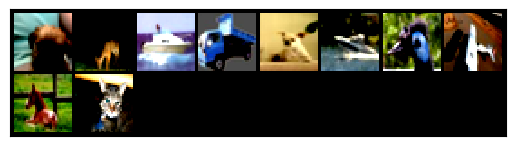

In [11]:
bx, _ =next(iter(training_loader))
bx = bx.to(device)
ic(bx.shape)
display_image_grid(bx)

## Convolution basics

https://www.telesens.co/2017/09/17/cnn_derivatives/

In [13]:
def show_image(image_tensor, title: str):
    # Convert the image tensor to a NumPy array
    image_np = image_tensor.squeeze().cpu().detach().numpy()
    image_np = np.transpose(image_np, (1, 2, 0))  # Rearrange dimensions to HWC

    # Display the image using matplotlib
    plt.figure(figsize=(1, 1))
    plt.imshow(image_np)
    plt.title(title)
    plt.axis("off")  # Turn off axis labels
    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.60784316].


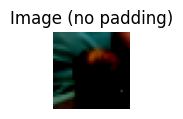

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.60784316].


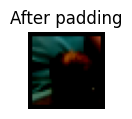

ic| input_height: 36
    input_width: 36
    kernel_height: 3
    kernel_width: 3
ic| output_height: 34, output_width: 34


In [14]:
stride = 1
kernel_size = 3
padding = 2
in_channels = 3
out_channels = 3

x = bx[0].unsqueeze(0)
show_image(x, "Image (no padding)")
if padding>0:
    x = F.pad(x, (padding, padding, padding, padding))
    show_image(x, "After padding")


batch_size, in_channels, input_height, input_width = x.size()
#out_channels, _, kernel_height, kernel_width = kernel_weight.size()
kernel_height, kernel_width = kernel_size, kernel_size
ic(input_height, input_width,kernel_height, kernel_width)


# Calculate the dimensions of the output tensor
output_height = (input_height - kernel_height) // stride + 1
output_width = (input_width - kernel_width) // stride + 1
ic(output_height, output_width)

# Initialize the output tensor
output = torch.zeros(batch_size, out_channels, output_height, output_width)

ic| vertical_line_kernel.shape: torch.Size([3, 3, 3, 3])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.0117655..3.2078435].


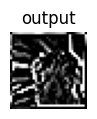

In [15]:
# Convolution logic
vertical_line_kernel = torch.tensor(
    [[[[1, 0, -1], [1, 0, -1], [1, 0, -1]]]], dtype=torch.float32
).to(device)
# Replicate the kernel for each input channel (R, G, B) and each output channel. 
vertical_line_kernel = vertical_line_kernel.repeat(3, 3, 1, 1)
ic(vertical_line_kernel.shape)

horiz_line_kernel = torch.tensor([[[1, 1, 1], [0, 0, 0], [-1, -1, -1]]], dtype=torch.float32).to(device).repeat(3,3,1,1)

# Laplacian filter, which detects edges regardless of their orientation.
laplacian_kernel = torch.tensor([[[ 0,  1,  0],
 [ 1, -4,  1],
 [ 0,  1,  0]]], dtype=torch.float32).to(device).repeat(3,3,1,1)

kernel_weight = vertical_line_kernel
kernel_weight = horiz_line_kernel
kernel_weight = laplacian_kernel
kernel_bias = torch.randn(out_channels).to(device)

for i in range(0, input_height - kernel_height + 1, stride):
    for j in range(0, input_width - kernel_width + 1, stride):
        region = x[:, :, i : i + kernel_height, j : j + kernel_width]              
        #rk = region * kernel_weight
        #output[:, :, i // stride, j // stride] = torch.sum(rk, dim=(1,2,3)) #+ kernel_bias
        output[:, :, i // stride, j // stride]=torch.tensordot(region, kernel_weight,dims=([1,2,3], [1, 2, 3]))#+kernel_bias

show_image(output, "output")

ic| conv.weight.shape: torch.Size([3, 3, 3, 3])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.0117655..3.2078433].


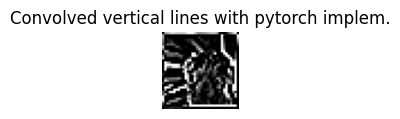

In [16]:
# Check results with pytorch implementation
# Define a convolution layer with the pre-defined kernel
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, groups=1, bias=False).to(device)
conv.weight = nn.Parameter(vertical_line_kernel)
conv.weight = nn.Parameter(horiz_line_kernel)
conv.weight = nn.Parameter(laplacian_kernel)
ic(conv.weight.shape)

# Apply the convolution
output = conv(x)


show_image(output, "Convolved vertical lines with pytorch implem.")

https://github.com/MishaLaskin/vqvae/tree/master

## Pooling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61960787..3.2078433].


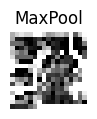

In [21]:

def max_pool2d(input, kernel_size, stride):
    batch_size, channels, height, width = input.size()
    output_height = (height - kernel_size) // stride + 1
    output_width = (width - kernel_size) // stride + 1
    
    output = torch.zeros((batch_size, channels, output_height, output_width), device=input.device)
    
    for b in range(batch_size):
        for c in range(channels):
            for i in range(0, height - kernel_size + 1, stride):
                for j in range(0, width - kernel_size + 1, stride):
                    h_start, h_end = i, i + kernel_size
                    w_start, w_end = j, j + kernel_size
                    output[b, c, i // stride, j // stride] = torch.max(input[b, c, h_start:h_end, w_start:w_end])
                    
    return output

# Example usage

max_output = max_pool2d(output, kernel_size=2, stride=2)
show_image(max_output,"MaxPool")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61960787..3.2078433].


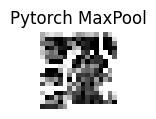

In [23]:
# Check if pytorch maxpool is the same. 
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

# Apply the Max Pooling layer to the input tensor
max_output = max_pool(output)
show_image(max_output,"Pytorch MaxPool")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61960787..3.2078433].


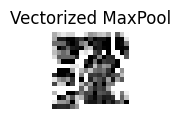

In [25]:
def vectorized_max_pool2d(input, kernel_size, stride):
    # Use unfold to extract sliding local blocks from a batched input tensor
    unfolded = input.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
    # Now unfolded tensor has shape: (batch_size, channels, output_height, output_width, kernel_size, kernel_size)
    # Reshape to merge the kernel dimensions
    unfolded = unfolded.contiguous().view(*unfolded.size()[:4], -1)
    # Apply max operation over the last dimension (which contains the kernel elements)
    output, _ = unfolded.max(dim=-1)
    return output

max_output = vectorized_max_pool2d(output, kernel_size=2, stride=2)
show_image(max_output,"Vectorized MaxPool")